# Google Summer of Code Midterm Submission
## Improving Renaissance Spanish OCR with CNN-RNN Hybrids and Weighted Learning
### Kate O'Reilly, Trinity College Dublin

Package Installation

In [1]:
!pip install -r requirements.txt

^C


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/11.4 MB ? eta -:--:--
   --------- ------------------------------ 2.6/11.4 MB 11.6 MB/s eta 0:00:01
   -------------------- ------------------- 5.8/11.4 MB 11.4 MB/s eta 0:00:01
   ---------------------------- ----------- 8.1/11.4 MB 11.4 MB/s eta 0:00:01
   ------------------------------------- -- 10.7/11.4 MB 11.4 MB/s eta 0:00:01
   ---------------------------------------  11.3/11.4 MB 11.4 MB/s eta 0:00:01
   ---------------------------------------  11.3/11.4 MB 11.4 MB/s eta 0:00:01
   ---------------------------------------  11.3/11.4 MB 11.4 MB/s eta 0:00:01
   ---------------------------------------  11.3/11.4 MB 11.4 MB/s eta 0:00:01
   ---------------------------------------- 11.4/11.4 MB 6.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ------------- -------------------------- 2.6/7.8 

Reason for being yanked: So that users won't accidentally install this when using python 3.11
  DEPRECATION: Building 'promise' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'promise'. Discussion can be found at https://github.com/pypa/pip/issues/6334
ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\katej\\OneDrive\\Documents\\GitHub\\RenAIssance_fork\\cleanenv\\Lib\\site-packages\\tensorflow\\python\\keras\\saving\\model_config.py'
Check the permissions.



In [1]:
!pip install numpy==1.23.5 


  Using cached numpy-1.23.5-cp39-cp39-win_amd64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp39-cp39-win_amd64.whl (14.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.23.5 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
torchmetrics 1.7.2 requires torch>=2.0.0, but you have torch 1.10.2 which is incompatible.


Import Modules

In [1]:
# Data Pre-processing
import fitz
import cv2
import csv
import os
from docx import Document
import torch
import string
import requests
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from IPython.display import clear_output as cls
from pathlib import Path

# Data
from glob import glob
from tqdm import tqdm
import tensorflow.data as tfd

# Data Visualization
import matplotlib.pyplot as plt

# Model
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import layers

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#Update the path to your data directory
DATA_DIR = Path("data/")

If using the corrected data from Dataset_Preprocessing, you will need to invert the images

In [ ]:
from utils import invert_images_in_folder
                
invert_images_in_folder(DATA_DIR, DATA_DIR)

Inverted: (para.png
Inverted: (por.png
Inverted: (que (2).png
Inverted: (que.png
Inverted: 13.png
Inverted: 14.png
Inverted: 20.png
Inverted: 6.png
Inverted: 8.png
Inverted: A (10).png
Inverted: a (11).png
Inverted: a (12).png
Inverted: a (13).png
Inverted: a (14).png
Inverted: a (15).png
Inverted: a (16).png
Inverted: a (17).png
Inverted: a (18).png
Inverted: a (19).png
Inverted: a (2).png
Inverted: a (20).png
Inverted: a (21).png
Inverted: a (22).png
Inverted: a (23).png
Inverted: a (24).png
Inverted: a (25).png
Inverted: a (26).png
Inverted: a (27).png
Inverted: a (28).png
Inverted: a (29).png
Inverted: a (3).png
Inverted: a (30).png
Inverted: a (31).png
Inverted: a (32).png
Inverted: a (33).png
Inverted: a (34).png
Inverted: a (35).png
Inverted: a (36).png
Inverted: a (37).png
Inverted: a (38).png
Inverted: a (39).png
Inverted: a (4).png
Inverted: a (40).png
Inverted: A (5).png
Inverted: a (6).png
Inverted: a (7).png
Inverted: a (8).png
Inverted: a (9).png
Inverted: a.png
Inverted:

Fix any Decoding Errors from Spanish Glyphs in Filenames

In [2]:
import os
import sys
import re
from ftfy import fix_text

# 1) Whitelist of allowed characters (now including digits)
ALLOWED = set(
    " "                                    # space
    + "ABCDEFGHIJKLMNOPQRSTUVWXYZ"         # uppercase
    + "abcdefghijklmnopqrstuvwxyz"         # lowercase
    + "áéíóúÁÉÍÓÚñÑ"                        # Spanish letters
    + "0123456789"                         # digits
    + "¡¿(),.-"                            # punctuation (including parentheses)
)

# Build & escape the character class for regex
allowed_chars = "".join(sorted(ALLOWED))
escaped       = "".join(re.escape(c) for c in allowed_chars)
pattern       = re.compile(f"[^{escaped}]")

folder = "data/data_3"
fs_enc = sys.getfilesystemencoding()

for fname in os.listdir(folder):
    # 2) Recover the raw bytes of the filename via surrogateescape
    raw = fname.encode(fs_enc, errors="surrogateescape")
    
    # 3) Decode using UTF-8, fallback to CP1252
    try:
        decoded = raw.decode("utf-8")
    except UnicodeDecodeError:
        decoded = raw.decode("cp1252", errors="replace")
    
    # 4) Auto-fix common mojibake
    fixed = fix_text(decoded)
    
    # 5) Strip out any characters not in our whitelist
    clean = pattern.sub("", fixed)
    
    # 6) Collapse multiple spaces and trim
    clean = re.sub(r"\s+", " ", clean).strip()
    
    # 7) Remove any empty parentheses left behind
    clean = re.sub(r"\(\s*\)", "", clean)
    
    # 8) Re-attach the extension (preserve original if stripped)
    base, ext = os.path.splitext(clean)
    if ext.lower() not in (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"):
        _, orig_ext = os.path.splitext(fname)
        ext = orig_ext
        clean = base + ext
    
    src = os.path.join(folder, fname)
    dst = os.path.join(folder, clean)
    
    # 9) Rename only if the cleaned name differs
    if src != dst:
        if not os.path.exists(dst):
            os.rename(src, dst)
            print(f"Renamed: {fname!r} → {clean!r}")
        else:
            print(f"Skipped (target exists): {clean!r}")


Skipped (target exists): '10.png'
Skipped (target exists): '12.png'
Skipped (target exists): '13.png'
Skipped (target exists): '14.png'
Skipped (target exists): '15.png'
Skipped (target exists): '17.png'
Skipped (target exists): '18.png'
Skipped (target exists): '19.png'
Skipped (target exists): '1.png'
Skipped (target exists): '20.png'
Skipped (target exists): '21.png'
Skipped (target exists): '22.png'
Skipped (target exists): '23.png'
Skipped (target exists): '24.png'
Skipped (target exists): '26.png'
Skipped (target exists): '28.png'
Skipped (target exists): '29.png'
Skipped (target exists): '2.png'
Skipped (target exists): '30.png'
Skipped (target exists): '33.png'
Skipped (target exists): '3.png'
Skipped (target exists): '4.png'
Skipped (target exists): '5.png'
Skipped (target exists): '8.png'
Skipped (target exists): '9.png'
Renamed: 'ciencia; (2).png' → 'ciencia (2).png'
Skipped (target exists): 'cierto.png'
Renamed: 'ello; (2).png' → 'ello (2).png'
Skipped (target exists): 'ell

Create CSV with Filename and Identity

In [43]:
from utils import create_csv_from_folder

create_csv_from_folder("data/data_4", "csv/train_data_4.csv")
create_csv_from_folder("data/test_data/", "csv/test.csv")

CSV created at csv/train_data_4.csv with 705 entries.
CSV created at csv/test.csv with 163 entries.


In [27]:
create_csv_from_folder("testdata/", "csv/test_real_gothic.csv")

CSV created at csv/test_real_gothic.csv with 558 entries.


Create Validation CSV

In [64]:
from sklearn.model_selection import train_test_split

# Load full CSV
full_df = pd.read_csv("csv/train_data_4.csv")

# Split (e.g., 90% train, 10% val)
train_df, val_df = train_test_split(full_df, test_size=0.1, random_state=42, shuffle=True)

# Save new CSVs
train_df.to_csv("csv/train_data_4.csv", index=False)
val_df.to_csv("csv/val_data_4.csv", index=False)

print(f"[INFO] Training set: {len(train_df)} samples")
print(f"[INFO] Validation set: {len(val_df)} samples")


[INFO] Training set: 570 samples
[INFO] Validation set: 64 samples


Remove Filenames and Identities for Missing Images

In [28]:
clean_csv_missing_images("csv/test_real_gothic.csv", image_column="FILENAME")

No missing image files found.
Cleaned CSV saved to: csv/test_real_gothic.csv


,FILENAME,IDENTITY
0,"testdata\Burgos, Juan de. Valladolid 1500_p012...",Burgos Juan de Valladolid pword
1,"testdata\Burgos, Juan de. Valladolid 1500_p012...",Burgos Juan de Valladolid pword
2,"testdata\Burgos, Juan de. Valladolid 1500_p012...",Burgos Juan de Valladolid pword
3,"testdata\Burgos, Juan de. Valladolid 1500_p012...",Burgos Juan de Valladolid pword
4,"testdata\Burgos, Juan de. Valladolid 1500_p012...",Burgos Juan de Valladolid pword
...,...,...
553,"testdata\Burgos, Juan de. Valladolid 1500_p014...",Burgos Juan de Valladolid pword
554,"testdata\Burgos, Juan de. Valladolid 1500_p014...",Burgos Juan de Valladolid pword
555,"testdata\Burgos, Juan de. Valladolid 1500_p014...",Burgos Juan de Valladolid pword
556,"testdata\Burgos, Juan de. Valladolid 1500_p014...",Burgos Juan de Valladolid pword


In [65]:
from utils import clean_csv_missing_images

clean_csv_missing_images("csv/train_data_4.csv", image_column="FILENAME")
clean_csv_missing_images("csv/val_data_4.csv", image_column="FILENAME")

No missing image files found.
Cleaned CSV saved to: csv/train_data_4.csv
No missing image files found.
Cleaned CSV saved to: csv/val_data_4.csv


,FILENAME,IDENTITY
0,data\data_4\los (39).png,los
1,data\data_4\de (131).png,de
2,data\data_4\múdo.png,múdo
3,data\data_4\todos.png,todos
4,data\data_4\auctoridad.png,auctoridad
...,...,...
59,data\data_4\havia (2).png,havia
60,data\data_4\senado.png,senado
61,data\data_4\Los (32).png,Los
62,data\data_4\la (72).png,la


Model Configurations

In [12]:
IMG_HEIGHT = 32
IMG_WIDTH = 128
BATCH_SIZE = 32
HIDDEN_SIZE = 256
NUM_EPOCHS = 20

In [67]:
import pandas as pd

# Load data
train_df = pd.read_csv("csv/train_data_4.csv")
val_df = pd.read_csv("csv/val_data_4.csv")

# Build CHARSET from all data
all_text = ''.join(train_df['IDENTITY'].astype(str)) + ''.join(val_df['IDENTITY'].astype(str))
CHARSET = ''.join(sorted(set(all_text)))

print(f"[INFO] Character Set ({len(CHARSET)}): {repr(CHARSET)}")

# Build mappings
char_to_idx = {char: idx + 1 for idx, char in enumerate(CHARSET)}  # 0 is CTC blank
idx_to_char = {idx + 1: char for idx, char in enumerate(CHARSET)}
idx_to_char[0] = ''  # blank token for CTC


[INFO] Character Set (43): ' ABCDELMPQRSTabcdefghijlmnopqrstuvxyzáéíñóú'


In [68]:
with open("charset.txt", "r", encoding="utf-8") as f:
    CHARSET = f.read()

char_to_idx = {char: idx + 1 for idx, char in enumerate(CHARSET)}  # CTC blank = 0
idx_to_char = {idx + 1: char for idx, char in enumerate(CHARSET)}
idx_to_char[0] = ''  # blank


In [69]:
def find_unknown_chars(df, charset):
    all_text = ''.join(df['IDENTITY'].dropna().astype(str))
    return sorted(set(all_text) - set(charset))

print("Unknowns in train:", find_unknown_chars(train_df, CHARSET))
print("Unknowns in val:", find_unknown_chars(val_df, CHARSET))


Unknowns in train: []
Unknowns in val: []


Dataset Configurations

In [70]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch
from pathlib import Path
from urllib.parse import unquote
import unicodedata
import pandas as pd

def normalize_path(path):
    path = Path(str(path))
    try:
        path = unquote(str(path).encode("latin1").decode("utf-8"))
    except Exception:
        path = str(path)
    return unicodedata.normalize("NFC", path)

class OCRDataset(Dataset):
    def __init__(self, csv_path, transform=None, char_to_idx=None):
        self.df = pd.read_csv(csv_path, quotechar='"')
        self.df["IDENTITY"] = self.df["IDENTITY"].astype(str).str.strip()
        self.df = self.df[
            self.df["IDENTITY"].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0 and x.lower() != 'nan')
        ]

        self.transform = transform
        self.char_to_idx = char_to_idx  # <-- pass externally!

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = normalize_path(row['FILENAME'])
        label_str = unicodedata.normalize('NFC', str(row['IDENTITY']).strip())

        try:
            img = Image.open(img_path).convert("L")
        except Exception as e:
            raise FileNotFoundError(f"Could not open image: {img_path}\n{e}")

        img = img.resize((128, 32))
        img = np.array(img).astype(np.uint8)
        img = Image.fromarray(img, mode='L')

        if self.transform:
            img = self.transform(img)

        if self.char_to_idx is None:
            raise ValueError("char_to_idx mapping must be provided to OCRDataset.")
        label = [self.char_to_idx[c] for c in label_str if c in self.char_to_idx]
        return img, torch.tensor(label, dtype=torch.long), len(label), label_str


Collate Function

In [71]:
import torchvision.transforms as transforms

def collate_fn(batch):
    images, labels, label_lengths, label_strs = zip(*batch)

    # Ensure all images are tensors
    tensor_images = []
    for img in images:
        if not isinstance(img, torch.Tensor):
            img = transforms.ToTensor()(img)
        tensor_images.append(img)

    images = torch.stack(tensor_images)
    labels_concat = torch.cat(labels)
    label_lengths = torch.tensor(label_lengths, dtype=torch.long)

    return images, labels_concat, label_lengths, label_strs


CRNN Model (Custom Backbone)

In [72]:
class CRNN(nn.Module):
    def __init__(self, imgH, nc, nclass, nh):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0
        self.cnn = nn.Sequential(
            nn.Conv2d(nc, 64, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d(2, 2),                    # H: 32 → 16
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d(2, 2),                   # H: 16 → 8
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d((2, 2), (2, 1), (0, 1)), # H: 8 → 4
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.MaxPool2d((2, 2), (2, 1), (0, 1)),
            nn.AdaptiveAvgPool2d((1, None))                                             
        )

        self.rnn1 = nn.LSTM(512, nh, bidirectional=True)
        self.rnn2 = nn.LSTM(nh * 2, nh, bidirectional=True)
        
        self.embedding = nn.Linear(nh * 2, nclass)

    def forward(self, x):
        conv = self.cnn(x)

        b, c, h, w = conv.size()
        assert h == 1
        conv = conv.squeeze(2).permute(2, 0, 1)  # [w, b, c]
        rnn_out, _ = self.rnn1(conv)
        rnn_out, _ = self.rnn2(rnn_out)
        output = self.embedding(rnn_out)
        return output

Greedy Decoder

In [73]:
def decode(output):
    out = output.softmax(2)
    _, max_idx = out.max(2)
    max_idx = max_idx.transpose(1, 0)

    texts = []
    for pred in max_idx:
        pred = pred.cpu().numpy()
        chars = []
        prev = -1
        for p in pred:
            if p != prev and p != 0:
                chars.append(idx_to_char[p])
            prev = p
        texts.append(''.join(chars))
    return texts

Beam Decoder

In [74]:
def ctc_beam_search_decoder(probs, charset, beam_width=10, blank_index=0):
    T, C = probs.shape  # [T, C]
    beams = [("", 1.0)]  # list of (sequence, score)

    for t in range(T):
        new_beams = []
        for prefix, score in beams:
            for c in range(C):
                p = probs[t, c]
                new_seq = prefix + (charset[c] if c != blank_index else "")
                new_score = score * p
                new_beams.append((new_seq, new_score))
        # Keep top N beams
        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

    return beams[0][0]  # return best sequence


Training Utilities

In [75]:
def save_checkpoint(model, optimizer, epoch, path='crnn_checkpoint.pth'):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)

def load_checkpoint(model, optimizer, path='crnn_checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch']

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


Load Data

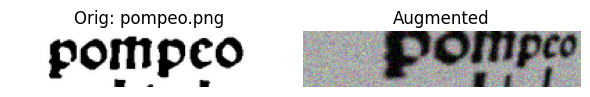

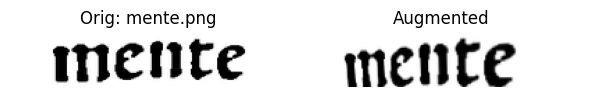

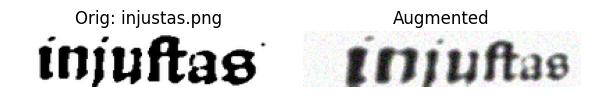

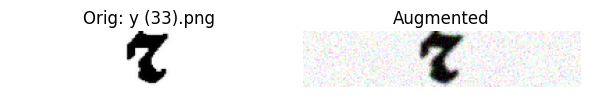

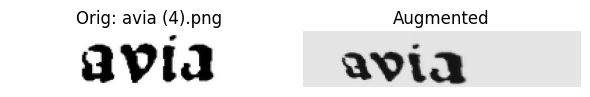

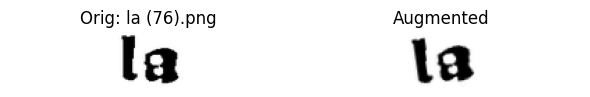

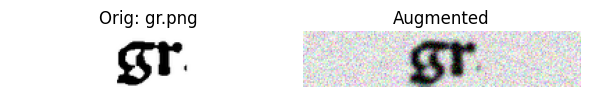

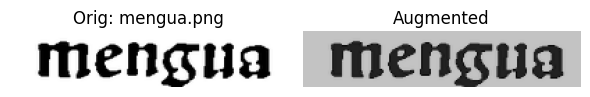

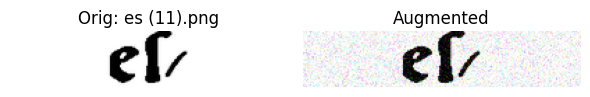

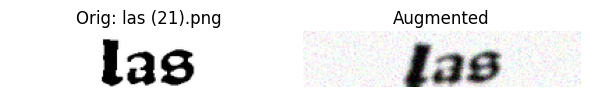

In [76]:
# ─── DATA AUGMENTATION SAMPLE ───
import random
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1) Define heavy augmentation function
def augment(img):
    h, w = img.shape[:2]
    # Random rotation
    if random.random() < 0.7:
        angle = random.uniform(-10, 10)
        M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
        img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    # Random perspective warp
    if random.random() < 0.5:
        pts1 = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
        pts2 = pts1 + np.random.randint(-15, 15, size=(4, 2)).astype(np.float32)
        M2 = cv2.getPerspectiveTransform(pts1, pts2)
        img = cv2.warpPerspective(img, M2, (w, h), borderMode=cv2.BORDER_REPLICATE)
    # Random Gaussian blur
    if random.random() < 0.5:
        k = random.choice([5, 7])  # kernel size
        img = cv2.GaussianBlur(img, (k, k), 0)
    # Random brightness/contrast
    if random.random() < 0.7:
        alpha = random.uniform(0.6, 1.4)  # contrast
        beta = random.uniform(-40, 40)    # brightness
        img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    # Random noise
    if random.random() < 0.5:
        noise = np.random.randn(h, w, 3) * random.uniform(15, 30)
        img = img.astype(np.float32) + noise
        img = np.clip(img, 0, 255).astype(np.uint8)
    return img

# 2) Sample a few images
folder = Path("data/data_4")
images = list(folder.glob("*.png"))
if len(images) == 0:
    raise ValueError(f"No images found in {folder}")
sample_paths = random.sample(images, k=min(10, len(images)))

# 3) Display original and augmented samples
for idx, img_path in enumerate(sample_paths, start=1):
    # Load and convert
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # type: ignore
    aug_img = augment(img)

    # Plot
    plt.figure(figsize=(6, 3))
    # Original
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Orig: {img_path.name}")
    plt.axis('off')
    # Augmented
    plt.subplot(1, 2, 2)
    plt.imshow(aug_img)
    plt.title("Augmented")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


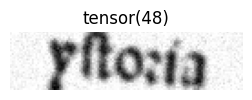

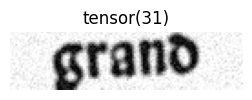

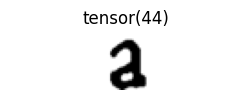

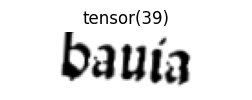

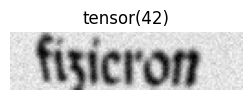

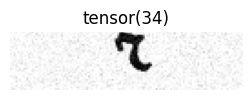

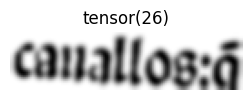

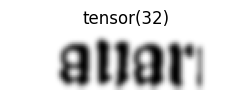

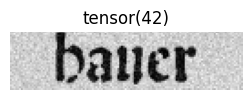

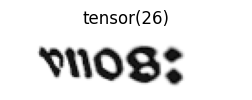

In [81]:
# ─── FULL CELL: GRAYSCALE-SAFE AUGMENTATION + PyTorch PIPELINE ───
import random
import re
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd



# --- 2) Define heavy augmentation (NumPy) ---
def augment(img: np.ndarray) -> np.ndarray:
    # img is RGB or grayscale turned to 3-channel BGR
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    h, w = img.shape[:2]
    # rotation
    if random.random() < 0.7:
        ang = random.uniform(-5, 5)
        M = cv2.getRotationMatrix2D((w/2, h/2), ang, 1.0)
        img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    # perspective
    if random.random() < 0.5:
        pts1 = np.float32([[0,0],[w,0],[0,h],[w,h]])
        pts2 = pts1 + np.random.randint(-10,10,(4,2)).astype(np.float32)
        M2 = cv2.getPerspectiveTransform(pts1, pts2)
        img = cv2.warpPerspective(img, M2, (w,h), borderMode=cv2.BORDER_REPLICATE)
    # blur
    if random.random() < 0.5:
        k = random.choice([5,7])
        img = cv2.GaussianBlur(img, (k,k), 0)
    # brightness/contrast
    if random.random() < 0.7:
        a = random.uniform(0.6,1.4); b = random.uniform(-40,40)
        img = cv2.convertScaleAbs(img, alpha=a, beta=b)
    # noise
    if random.random() < 0.5:
        noise = np.random.randn(h, w, img.shape[2]) * random.uniform(15,30)
        img = img.astype(np.float32) + noise
        img = np.clip(img, 0, 255).astype(np.uint8)
    return img

# --- 3) Wrap augment() for torchvision **and** convert back to grayscale ---
augment_tf = transforms.Lambda(lambda pil: 
    Image.fromarray(
        # augment returns BGR in NumPy; convert RGB->BGR then back to GRAY
        cv2.cvtColor(
            augment(cv2.cvtColor(np.array(pil), cv2.COLOR_RGB2BGR)),
            cv2.COLOR_BGR2GRAY
        )
    )
)

train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    augment_tf,                  # heavy augment -> grayscale PIL
    transforms.ToTensor(),       # gives shape [1,H,W]
    transforms.Normalize([0.5], [0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),       # grayscale -> [1,H,W]
    transforms.Normalize([0.5], [0.5])
])

# --- 5) Import your dataset & collate ---

# --- 6) DataLoader with cleaned CSV ---
clean_csv = "csv/train_data_4.csv"  # or your CSV path
train_ds = OCRDataset(clean_csv, transform=train_transform, char_to_idx=char_to_idx)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

# --- 7) Visualize a few augmented samples ---
batch = next(iter(train_loader))
imgs, labels = batch[0], batch[1]  # now imgs.shape = [B,1,32,128]

for i in range(min(10, imgs.size(0))):
    im = imgs[i].permute(1,2,0).squeeze(-1).numpy()  # H x W
    plt.figure(figsize=(3,1.5))
    plt.imshow(im, cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
    plt.show()


In [79]:
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd

transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)), 
    transforms.ToTensor(),                      
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])

train_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.RandomRotation(degrees=5),              # small rotations
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # light variation
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # shift
    ], p=0.8),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = OCRDataset("csv/train.csv", transform=train_transform, char_to_idx=char_to_idx)
val_dataset = OCRDataset("csv/val.csv", transform=val_transform, char_to_idx=char_to_idx)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [82]:
val_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
val_dataset = OCRDataset("csv/val_data_4.csv", transform=val_transform, char_to_idx=char_to_idx)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

Training Loop

In [83]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5, verbose=True
)

early_stopper = EarlyStopping(patience=5)
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels_concat, label_lengths, _ in train_loader:
        images = images.to(DEVICE)
        labels_concat = labels_concat.to(DEVICE)

        outputs = model(images)
        input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long).to(DEVICE)

        loss = criterion(outputs.log_softmax(2), labels_concat, input_lengths, label_lengths.to(DEVICE))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels_concat, label_lengths, _ in val_loader:
            images = images.to(DEVICE)
            labels_concat = labels_concat.to(DEVICE)
            outputs = model(images)
            input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long).to(DEVICE)
            loss = criterion(outputs.log_softmax(2), labels_concat, input_lengths, label_lengths.to(DEVICE))
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_checkpoint(model, optimizer, epoch, path='real_augmented_gothic.pth')
        print("Saved best model.")

    if early_stopper.step(avg_val_loss):
        print("Early stopping triggered.")
        break


Epoch 1, Train Loss: 7.0505, Val Loss: 3.5004
Saved best model.
Epoch 2, Train Loss: 3.8230, Val Loss: 3.4831
Saved best model.
Epoch 3, Train Loss: 3.7323, Val Loss: 3.4837
Epoch 4, Train Loss: 3.6741, Val Loss: 3.4243
Saved best model.
Epoch 5, Train Loss: 3.5614, Val Loss: 3.3929
Saved best model.
Epoch 6, Train Loss: 3.4895, Val Loss: 3.4114
Epoch 7, Train Loss: 3.4415, Val Loss: 3.3024
Saved best model.
Epoch 8, Train Loss: 3.3808, Val Loss: 3.2675
Saved best model.
Epoch 9, Train Loss: 3.3506, Val Loss: 3.2233
Saved best model.
Epoch 10, Train Loss: 3.3042, Val Loss: 3.2173
Saved best model.
Epoch 11, Train Loss: 3.2654, Val Loss: 3.1584
Saved best model.
Epoch 12, Train Loss: 3.2288, Val Loss: 3.1227
Saved best model.
Epoch 13, Train Loss: 3.1972, Val Loss: 3.1054
Saved best model.
Epoch 14, Train Loss: 3.1601, Val Loss: 3.0874
Saved best model.
Epoch 15, Train Loss: 3.1265, Val Loss: 3.0810
Saved best model.
Epoch 16, Train Loss: 3.1039, Val Loss: 3.0880
Epoch 17, Train Loss: 3

Further Train

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)

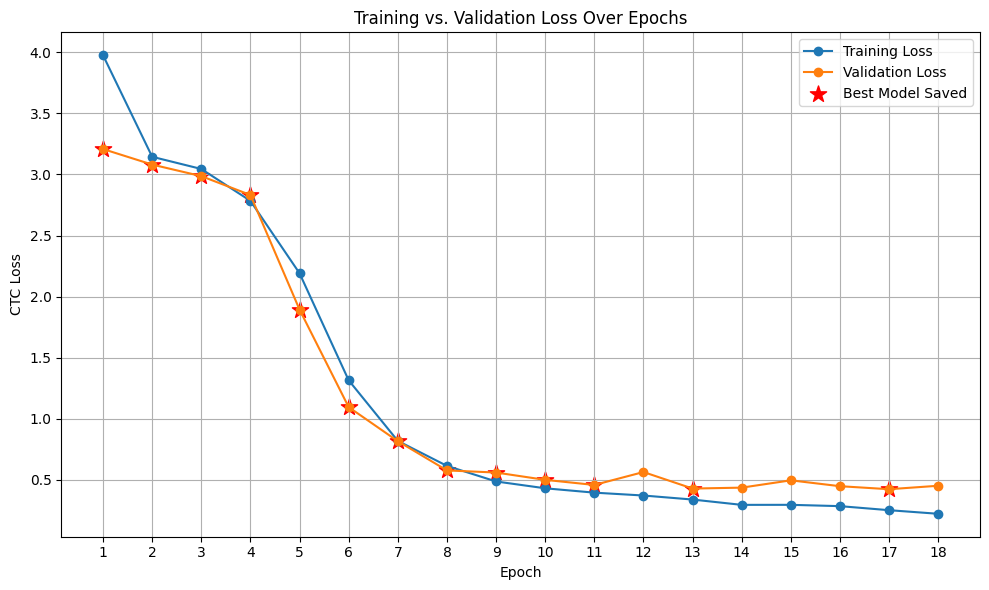

In [ ]:
import matplotlib.pyplot as plt

# Manually Extract training and validation losses
train_losses = [
    3.9753, 3.1443, 3.0445, 2.7836, 2.1908, 1.3146,
    0.8188, 0.6142, 0.4867, 0.4308, 0.3952, 0.3717,
    0.3387, 0.2952, 0.2955, 0.2847, 0.2516, 0.2221
]

val_losses = [
    3.2075, 3.0805, 2.9859, 2.8315, 1.8933, 1.0951,
    0.8164, 0.5772, 0.5598, 0.4999, 0.4582, 0.5639,
    0.4286, 0.4362, 0.4960, 0.4480, 0.4233, 0.4516
]

# Best epochs where the model was saved
best_epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 17]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')

# Highlight best validation points
best_val_losses = [val_losses[i - 1] for i in best_epochs]
best_val_epochs = [i - 1 for i in best_epochs]
plt.scatter(best_val_epochs, best_val_losses, color='red', marker='*', s=150, label='Best Model Saved')

plt.title('Training vs. Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('CTC Loss')
plt.xticks(range(len(train_losses)), range(1, len(train_losses) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Visual Evaluation

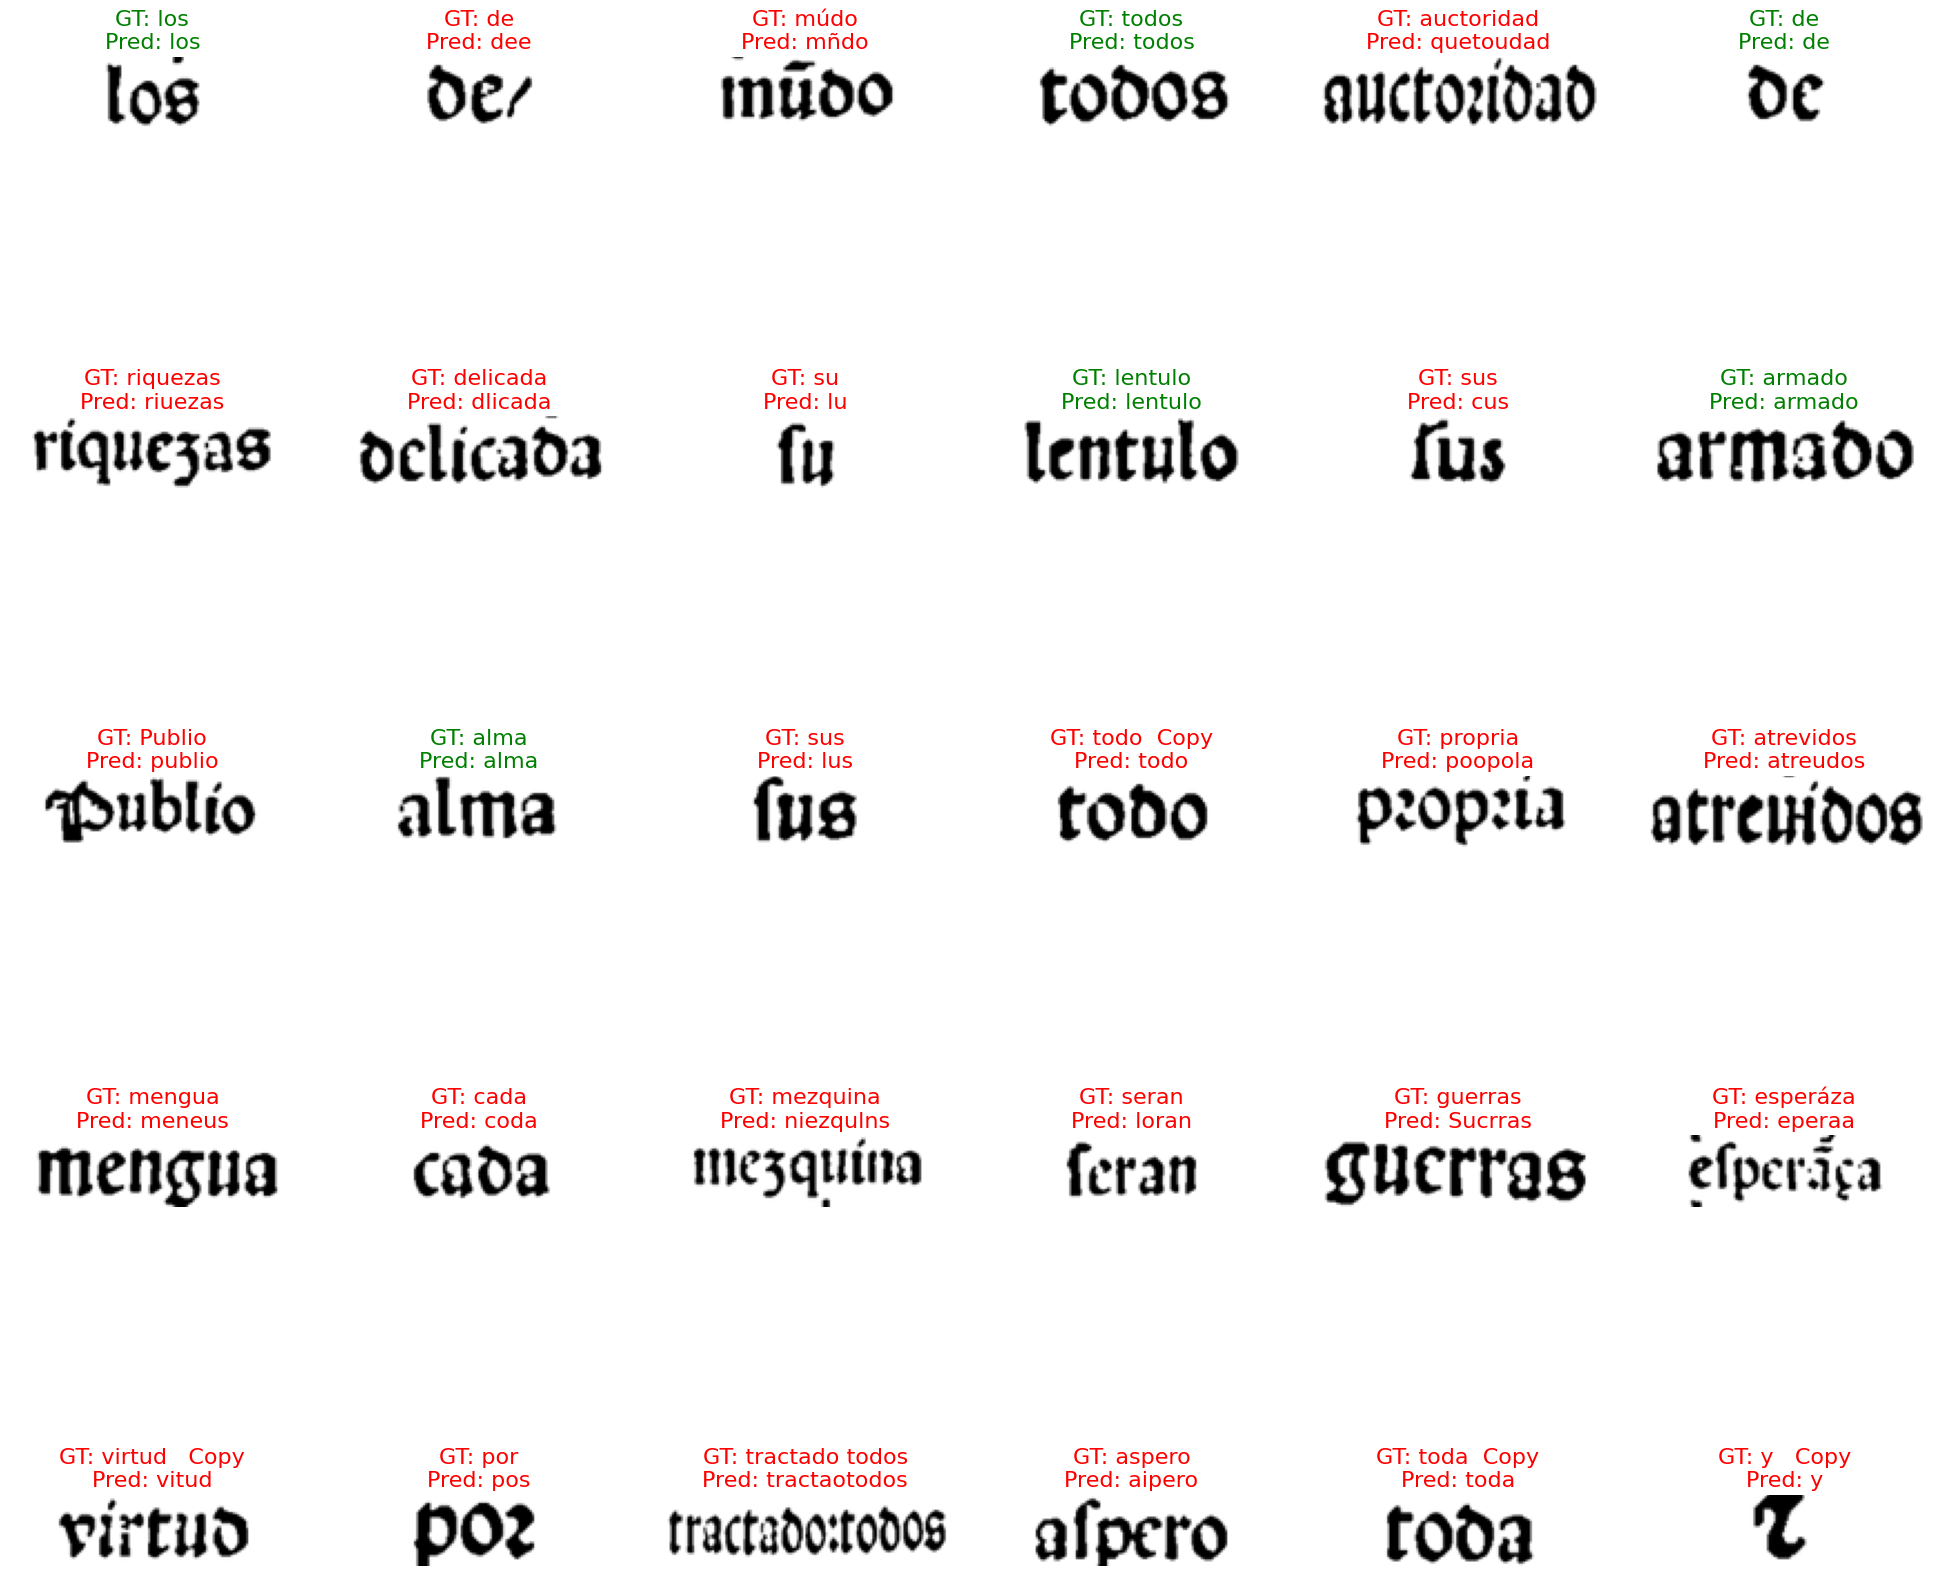

In [84]:
import torch
import matplotlib.pyplot as plt
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Rebuild the model and load saved weights
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("synthetic_augmented_gothic.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()


with torch.no_grad():
    images, _, _, label_strs = next(iter(val_loader))
    images = images.to(DEVICE)
    outputs = model(images)
    preds = decode(outputs)

    num_images = min(30, len(images))
    cols = 6
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(20, rows * 4))

    for i in range(num_images):
        img_np = images[i].cpu().squeeze().numpy() * 0.5 + 0.5
        gt = label_strs[i]
        pred = preds[i]
        correct = (gt == pred)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_np, cmap='gray')

        title_color = 'green' if correct else 'red'
        plt.title(f"GT: {gt}\nPred: {pred}", fontsize=16, color=title_color)
        plt.axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()


In [32]:
import torch
import numpy as np
from collections import defaultdict
from jiwer import cer, wer

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Rebuild and load model
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Evaluation on full validation set
gt_texts = []
greedy_preds = []
beam_preds = []

with torch.no_grad():
    for images, _, _, label_strs in val_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        log_probs = outputs.log_softmax(2).cpu()

        T, B, C = log_probs.shape
        greedy_preds.extend(decode(log_probs))

        for b in range(B):
            probs_np = log_probs[:, b, :].exp().numpy()
            beam_pred = ctc_beam_search_decoder(probs_np, CHARSET, beam_width=5)
            beam_preds.append(beam_pred)

        gt_texts.extend(label_strs)

# Global CER/WER
print(f"\nEvaluation on {len(gt_texts)} samples")
print(f"Greedy   CER: {cer(' '.join(gt_texts), ' '.join(greedy_preds)):.4f} | WER: {wer(' '.join(gt_texts), ' '.join(greedy_preds)):.4f}")
print(f"Beam     CER: {cer(' '.join(gt_texts), ' '.join(beam_preds)):.4f} | WER: {wer(' '.join(gt_texts), ' '.join(beam_preds)):.4f}")

# Per-sample CERs
print("\nPer-sample CER (first 20 shown):")
for i, (gt, g_pred, b_pred) in enumerate(zip(gt_texts, greedy_preds, beam_preds)):
    print(f"\nSample {i+1}")
    print(f"GT:     {gt}")
    print(f"Greedy: {g_pred}")
    print(f"  CER: {cer(gt, g_pred):.2f}")
    print(f"Beam:   {b_pred}")
    print(f"  CER: {cer(gt, b_pred):.2f}")
    if i >= 19:
        break  # Show first 20 samples only


IndexError: string index out of range

Store Misidentified From the Val set for further incorporation later to target Specific Mischaracterisations.

In [33]:
import os
from torchvision.utils import save_image

# Create folder to store bad samples
os.makedirs("bad_preds", exist_ok=True)

model.eval()
failed_samples = []

with torch.no_grad():
    images, _, _, label_strs = next(iter(val_loader))
    images = images.to(DEVICE)
    outputs = model(images)
    preds = decode(outputs)

    for i in range(len(images)):
        gt = label_strs[i]
        pred = preds[i]
        correct = (gt == pred)

        # Save and log only incorrect predictions
        if not correct:
            img_tensor = images[i].cpu()
            filename = f"bad_preds/img_{i:03d}_GT_{gt}_PRED_{pred}.png"

            # Log in memory
            failed_samples.append({
                "index": i,
                "ground_truth": gt,
                "prediction": pred,
                "image_path": filename
            })

            # Save image to disk
            save_image(img_tensor, filename)

# Optional: view list of failed samples
for sample in failed_samples:
    print(f"[FAIL] GT: {sample['ground_truth']} | PRED: {sample['prediction']} → {sample['image_path']}")


[FAIL] GT: un | PRED: on → bad_preds/img_007_GT_un_PRED_on.png
[FAIL] GT: aÃƒÂ±os | PRED: amnos → bad_preds/img_009_GT_aÃƒÂ±os_PRED_amnos.png
[FAIL] GT: prin | PRED: prim → bad_preds/img_010_GT_prin_PRED_prim.png
[FAIL] GT: espejo | PRED: espeyo → bad_preds/img_012_GT_espejo_PRED_espeyo.png
[FAIL] GT: lo | PRED: do → bad_preds/img_016_GT_lo_PRED_do.png
[FAIL] GT: Artifice | PRED: Artiñice → bad_preds/img_020_GT_Artifice_PRED_Artiñice.png
[FAIL] GT: M | PRED: Nl → bad_preds/img_023_GT_M_PRED_Nl.png
[FAIL] GT: passiones | PRED: pasiones → bad_preds/img_026_GT_passiones_PRED_pasiones.png
[FAIL] GT: cargo | PRED: carg → bad_preds/img_030_GT_cargo_PRED_carg.png


Using Greedy Decode for Now

In [85]:
from jiwer import wer, cer

# After decoding
pred_texts = preds
gt_texts = list(label_strs)  # Convert tuple to list

# Compute average metrics
avg_cer = cer(gt_texts, pred_texts)
avg_wer = wer(gt_texts, pred_texts)

print(f"CER: {avg_cer:.4f} | WER: {avg_wer:.4f}")


CER: 0.3198 | WER: 0.7297


Bad Predictions CSV

In [75]:
import pandas as pd

df_bad = pd.DataFrame(failed_samples)  # from your earlier list
df_bad.to_csv("csv/bad_preds.csv", index=False)


In [76]:
class BadPredictionDataset(Dataset):
    def __init__(self, csv_path, transform, charset):
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.charset = charset
        self.char_to_idx = {c: i + 1 for i, c in enumerate(charset)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['image_path']).convert('L')
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        img = self.transform(img)
        label_str = row['ground_truth']
        label = [self.char_to_idx[c] for c in label_str if c in self.char_to_idx]
        return img, torch.tensor(label, dtype=torch.long), len(label), label_str


In [77]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

bad_dataset = BadPredictionDataset('data/bad_preds.csv', transform=transform, charset=CHARSET)
bad_loader = DataLoader(bad_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)



Create New Dataset using New Data

In [ ]:
import gdown
import zipfile
import os

# Google Drive file ID of the ZIP file
DATA_DIR = 'data/Word.zip'

# Construct download URL
gdown.download(f'https://drive.google.com/file/1oPAjtp4aKGPXDksLSzU3WiCgj_m09ADB', DATA_DIR, quiet=False)

# Unzip the downloaded file
with zipfile.ZipFile(DATA_DIR, 'r') as zip_ref:
    zip_ref.extractall('unzipped_folder')

# Optional: remove the zip file after extraction
os.remove(DATA_DIR)

DATA_DIR = 'data/Word'


In [35]:
from utils import pad_and_resize_images, create_csv_from_folder
DATA_DIR = Path("data/Word")
pad_and_resize_images(DATA_DIR)
create_csv_from_folder(DATA_DIR, "csv/train_new_data.csv")

Processed: data\Word\Word\cropped\&.jpg
Processed: data\Word\Word\cropped\(47).jpg
Processed: data\Word\Word\cropped\(49).jpg
Processed: data\Word\Word\cropped\(51).jpg
Processed: data\Word\Word\cropped\(53).jpg
Processed: data\Word\Word\cropped\(55).jpg
Processed: data\Word\Word\cropped\(58).jpg
Processed: data\Word\Word\cropped\(6.jpg
Processed: data\Word\Word\cropped\(61.jpg
Processed: data\Word\Word\cropped\(aun.jpg
Processed: data\Word\Word\cropped\(Christianamen.jpg
Processed: data\Word\Word\cropped\(pero.jpg
Processed: data\Word\Word\cropped\, como.jpg
Processed: data\Word\Word\cropped\,acusado.jpg
Processed: data\Word\Word\cropped\,como_1.jpg
Processed: data\Word\Word\cropped\,como_2.jpg
Processed: data\Word\Word\cropped\,con.jpg
Processed: data\Word\Word\cropped\,de.jpg
Processed: data\Word\Word\cropped\,ne.jpg
Processed: data\Word\Word\cropped\,qui.jpg
Processed: data\Word\Word\cropped\,vel.jpg
Processed: data\Word\Word\cropped\1.per.jpg
Processed: data\Word\Word\cropped\109.

Combine with Previous CSV

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split

# --- Load all three sources ---
df1 = pd.read_csv("csv/train.csv")
df2 = pd.read_csv("csv/train_new_data.csv")
df_val = pd.read_csv("csv/val.csv")

# --- Combine all ---
combined_df = pd.concat([df1, df2, df_val], ignore_index=True)

# --- Clean up: remove missing or empty IDENTITYs ---
combined_df["IDENTITY"] = combined_df["IDENTITY"].astype(str).str.strip()
combined_df = combined_df[combined_df["IDENTITY"].astype(bool)]  # remove empty strings / NaN

# --- Optional: shuffle entire set ---
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
combined_df["FILENAME"] = combined_df["FILENAME"].apply(lambda x: str(Path(x).as_posix()))


# --- Split into 90% train, 10% val ---
train_df, val_df = train_test_split(combined_df, test_size=0.1, random_state=42)

# --- Save to disk ---
train_df.to_csv("csv/train_new.csv", index=False)
val_df.to_csv("csv/val_new.csv", index=False)

print(f"Final datasets:")
print(f" - train.csv: {len(train_df)} samples")
print(f" - val.csv:   {len(val_df)} samples")


Final datasets:
 - train.csv: 4882 samples
 - val.csv:   543 samples


New DataLoader

In [37]:
train_dataset = OCRDataset('csv/train_new.csv', transform=train_transform, char_to_idx=char_to_idx)
val_dataset = OCRDataset('csv/val_new.csv', transform=val_transform, char_to_idx=char_to_idx)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

Train on New Data

In [59]:
# Ensure DEVICE is defined
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)

# Load previous checkpoint
checkpoint = torch.load("synthetic_augmented_gothic.pth", map_location=DEVICE)
# Load all layers except the embedding layer (output layer)
state_dict = checkpoint["model_state_dict"]
model_state = model.state_dict()
# Remove embedding weights/bias if shape mismatch
for key in ["embedding.weight", "embedding.bias"]:
	if key in state_dict and model_state[key].shape != state_dict[key].shape:
		print(f"Skipping {key} due to shape mismatch: {model_state[key].shape} vs {state_dict[key].shape}")
		del state_dict[key]
model.load_state_dict(state_dict, strict=False)

# Optionally resume optimizer state (recommended for consistent learning rate behavior)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# Restore epoch number if needed:
start_epoch = checkpoint.get("epoch", 0) + 1


In [60]:

if model is None:
    raise ValueError("Model is not initialized. Please run the cell that initializes and loads the model before running this training loop.")

early_stopper = EarlyStopping(patience=3)
best_val_loss = float('inf')
criterion = nn.CTCLoss(blank=0, zero_infinity=True)

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels_concat, label_lengths, _ in train_loader:
        images = images.to(DEVICE)
        labels_concat = labels_concat.to(DEVICE)

        outputs = model(images)
        if outputs is None:
            raise ValueError("Model forward() returned None. Check your CRNN forward method.")
        input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long).to(DEVICE)
        loss = criterion(outputs.log_softmax(2), labels_concat, input_lengths, label_lengths.to(DEVICE))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels_concat, label_lengths, _ in val_loader:
            images = images.to(DEVICE)
            labels_concat = labels_concat.to(DEVICE)
            outputs = model(images)
            input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long).to(DEVICE)
            loss = criterion(outputs.log_softmax(2), labels_concat, input_lengths, label_lengths.to(DEVICE))
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_checkpoint(model, optimizer, epoch, path='model_synthetic.pth')
        print("Saved best model.")

    if early_stopper.step(avg_val_loss):
        print("Early stopping triggered.")
        break

Epoch 1, Train Loss: 1.6677, Val Loss: 1.0959
Saved best model.
Epoch 2, Train Loss: 1.0854, Val Loss: 1.0683
Saved best model.
Epoch 3, Train Loss: 0.9278, Val Loss: 0.8726
Saved best model.
Epoch 4, Train Loss: 0.8253, Val Loss: 0.7332
Saved best model.
Epoch 5, Train Loss: 0.7559, Val Loss: 0.7294
Saved best model.
Epoch 6, Train Loss: 0.7258, Val Loss: 0.7091
Saved best model.
Epoch 7, Train Loss: 0.6543, Val Loss: 0.6226
Saved best model.
Epoch 8, Train Loss: 0.6203, Val Loss: 0.5399
Saved best model.
Epoch 9, Train Loss: 0.5976, Val Loss: 0.6243
Epoch 10, Train Loss: 0.5687, Val Loss: 0.5590


In [36]:
import torch
import matplotlib.pyplot as plt
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Rebuild the model and load saved weights
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): Bat

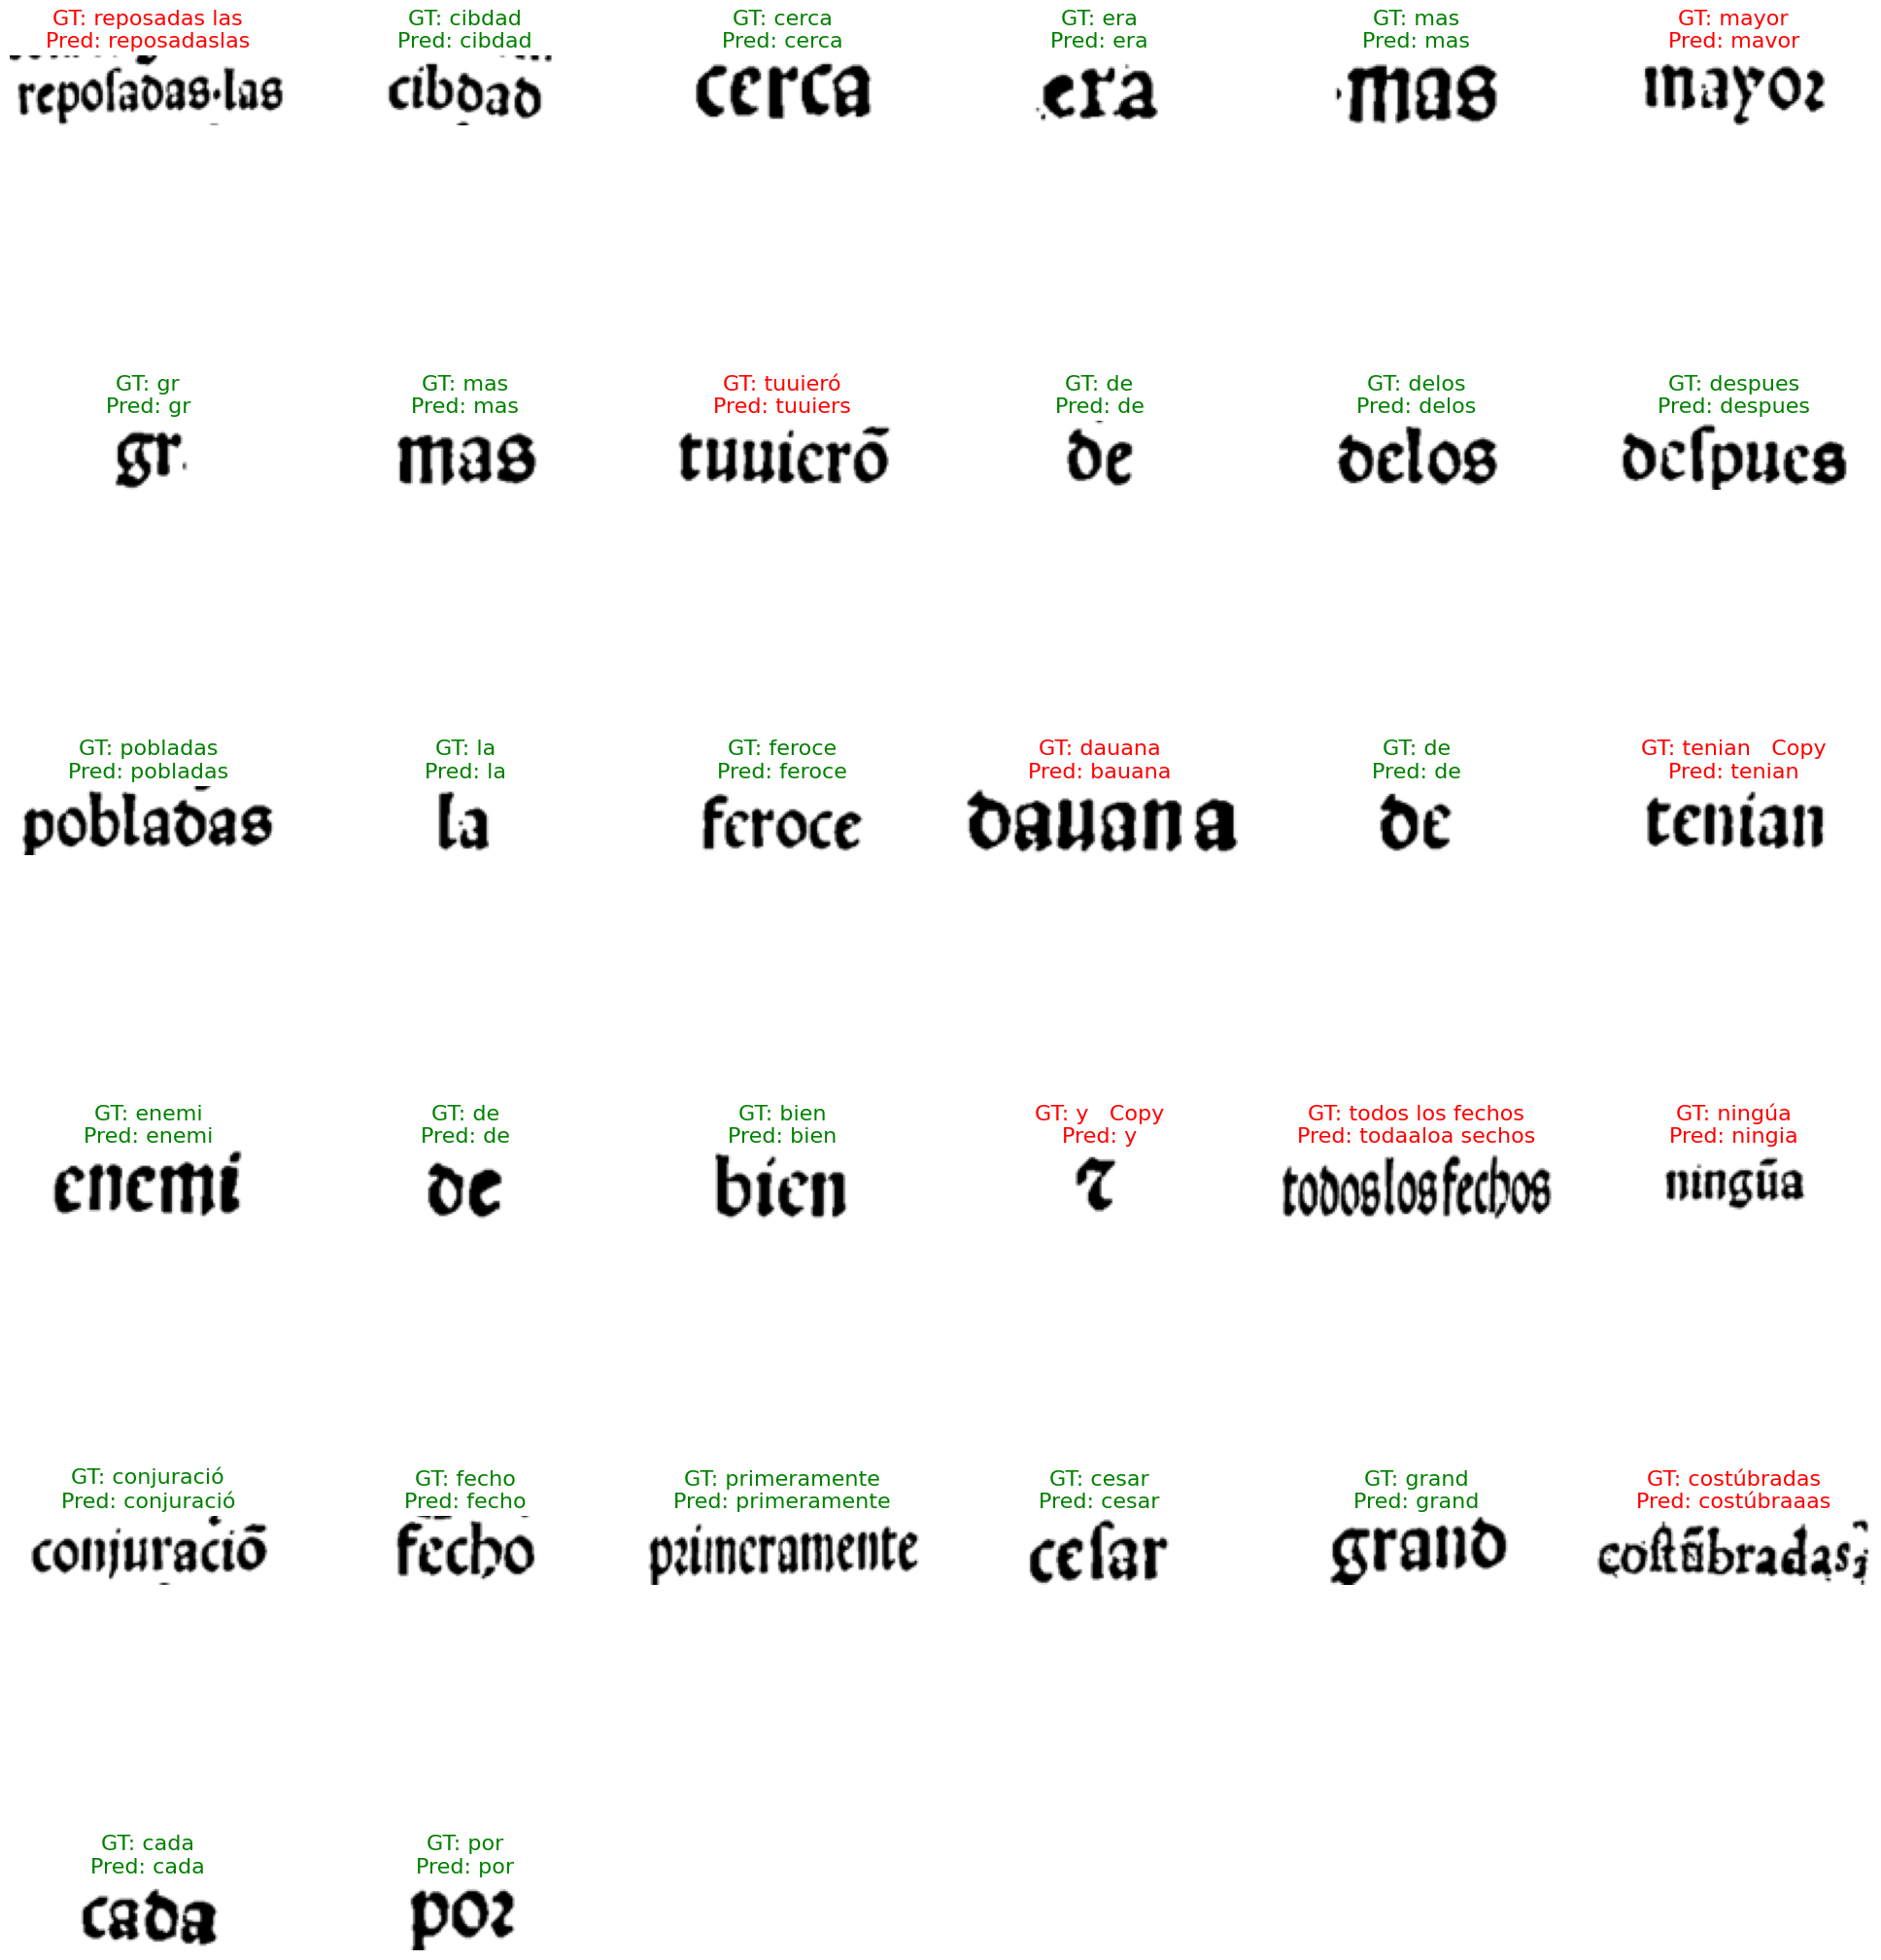

In [61]:
import torch
import matplotlib.pyplot as plt
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Rebuild the model and load saved weights
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("model_synthetic.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

with torch.no_grad():
    images, _, _, label_strs = next(iter(val_loader))
    images = images.to(DEVICE)
    outputs = model(images)
    preds = decode(outputs)

    num_images = min(32, len(images))
    cols = 6
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(20, rows * 4))

    for i in range(num_images):
        img_np = images[i].cpu().squeeze().numpy() * 0.5 + 0.5
        gt = label_strs[i]
        pred = preds[i]
        correct = (gt == pred)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_np, cmap='gray')

        title_color = 'green' if correct else 'red'
        plt.title(f"GT: {gt}\nPred: {pred}", fontsize=16, color=title_color)
        plt.axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()


FINAL CER AND WER 0.0338 0.0938

In [62]:
from jiwer import wer, cer

# After decoding
pred_texts = preds
gt_texts = list(label_strs)  # Convert tuple to list

# Ensure both lists are the same length
min_len = min(len(gt_texts), len(pred_texts))
gt_texts = gt_texts[:min_len]
pred_texts = pred_texts[:min_len]

# Compute average metrics
avg_cer = cer(gt_texts, pred_texts)
avg_wer = wer(gt_texts, pred_texts)

print(f"CER: {avg_cer:.4f} | WER: {avg_wer:.4f}")


CER: 0.1289 | WER: 0.3243


In [25]:
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class OCRTestDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image, img_path  # return path to identify output


In [39]:
import pandas as pd
from pathlib import Path

# Load validation CSV
val_df = pd.read_csv("csv/test_real_gothic.csv")

# Only keep rows where the image file still exists
val_df = val_df[val_df["FILENAME"].apply(lambda x: Path(x).is_file())]

# Sample N examples
n = 100
sampled = val_df.sample(n=min(n, len(val_df)), random_state=42).reset_index(drop=True)

# Remove the FILENAME column to create a test CSV
test_df = sampled[['FILENAME']]
test_df.to_csv("csv/test_gothic.csv", index=False)

print(f"Created test.csv with {len(test_df)} entries from valid files.")


Created test.csv with 100 entries from valid files.


In [40]:
test_dataset = OCRTestDataset('csv/test_gothic.csv', transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Test Model on Unlabelled Data

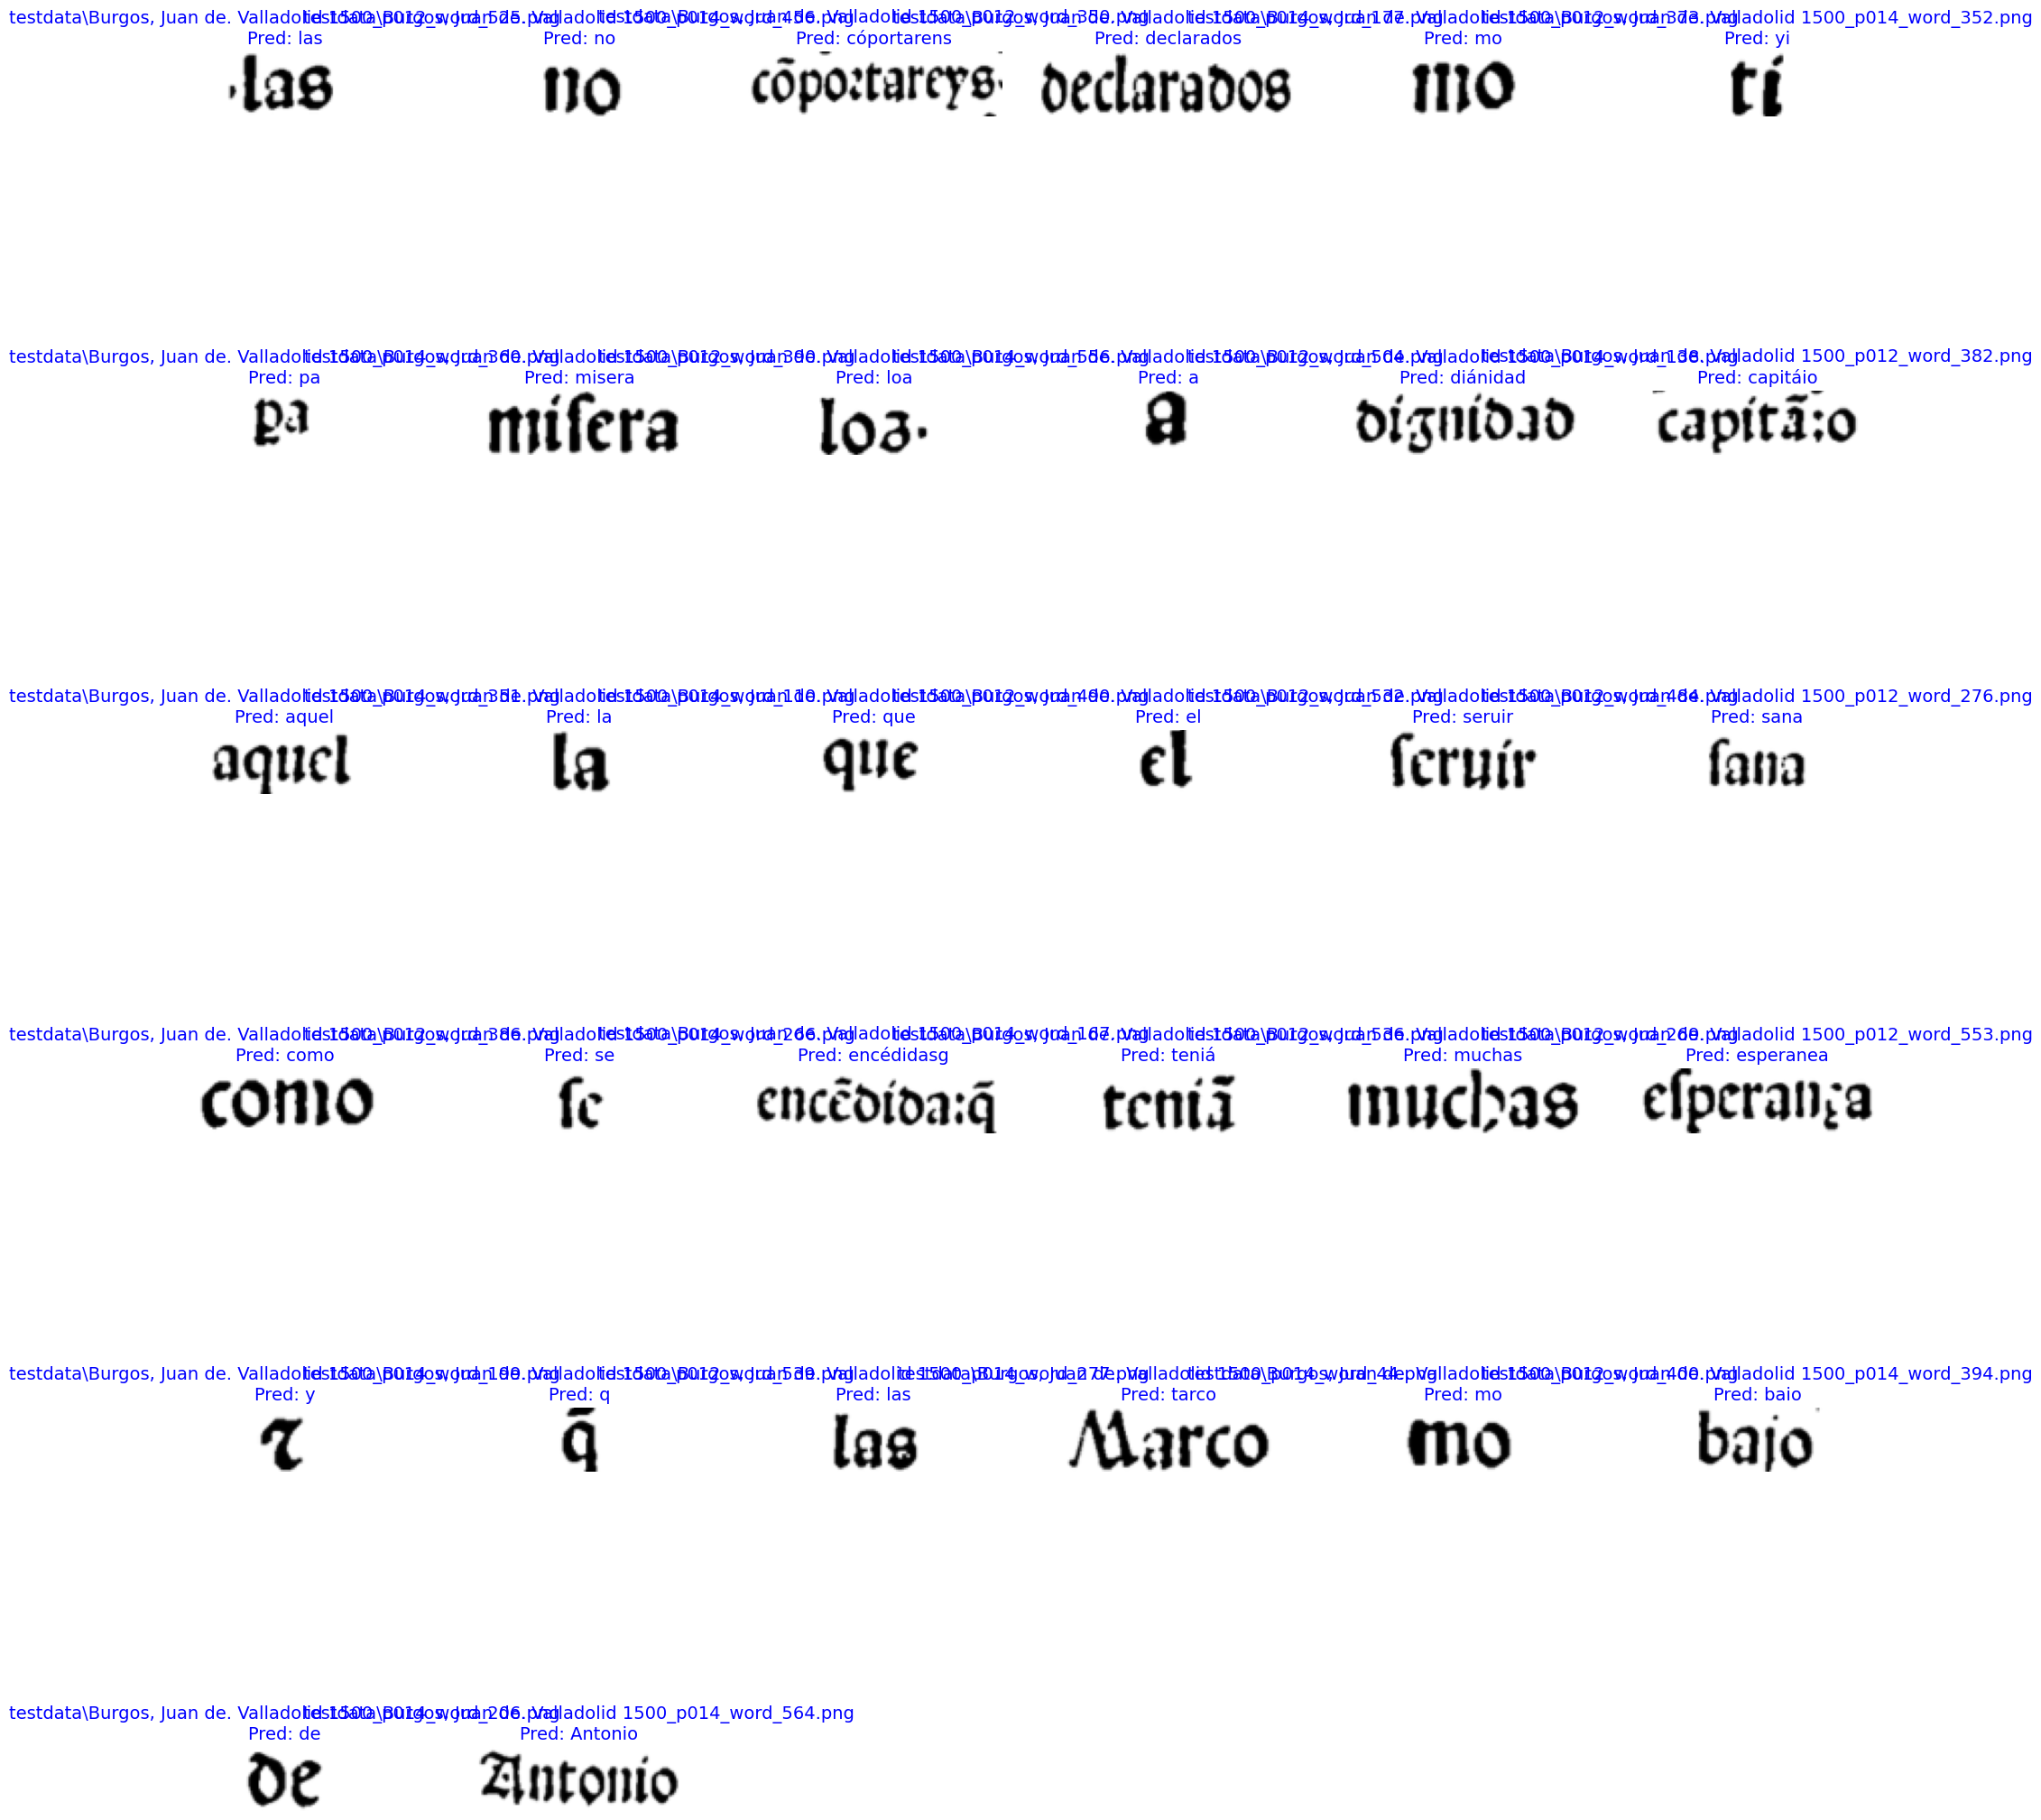

In [63]:
import torch
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Rebuild the model and load saved weights
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("model_synthetic.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

with torch.no_grad():
    images, paths = next(iter(test_loader))
    images = images.to(DEVICE)
    outputs = model(images)
    preds = decode(outputs)  # Greedy decoder

    num_images = min(32, len(images))
    cols = 6
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(20, rows * 4))

    for i in range(num_images):
        img_np = images[i].cpu().squeeze().numpy() * 0.5 + 0.5
        pred = preds[i]
        img_name = paths[i].split('/')[-1]  # filename only

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"{img_name}\nPred: {pred}", fontsize=14, color='blue')
        plt.axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()


In [38]:
from utils import pad_and_resize_images
pad_and_resize_images("testdata/")

Processed: testdata/Burgos, Juan de. Valladolid 1500_p012_word_260.png
Processed: testdata/Burgos, Juan de. Valladolid 1500_p012_word_264.png
Processed: testdata/Burgos, Juan de. Valladolid 1500_p012_word_265.png
Processed: testdata/Burgos, Juan de. Valladolid 1500_p012_word_266.png
Processed: testdata/Burgos, Juan de. Valladolid 1500_p012_word_267.png
Processed: testdata/Burgos, Juan de. Valladolid 1500_p012_word_268.png
Processed: testdata/Burgos, Juan de. Valladolid 1500_p012_word_269.png
Processed: testdata/Burgos, Juan de. Valladolid 1500_p012_word_270.png
Processed: testdata/Burgos, Juan de. Valladolid 1500_p012_word_274.png
Processed: testdata/Burgos, Juan de. Valladolid 1500_p012_word_275.png
Processed: testdata/Burgos, Juan de. Valladolid 1500_p012_word_276.png
Processed: testdata/Burgos, Juan de. Valladolid 1500_p012_word_280.png
Processed: testdata/Burgos, Juan de. Valladolid 1500_p012_word_282.png
Processed: testdata/Burgos, Juan de. Valladolid 1500_p012_word_283.png
Proces

Visually Inspect Misidentified Samples To See if any Data is Mislabelled

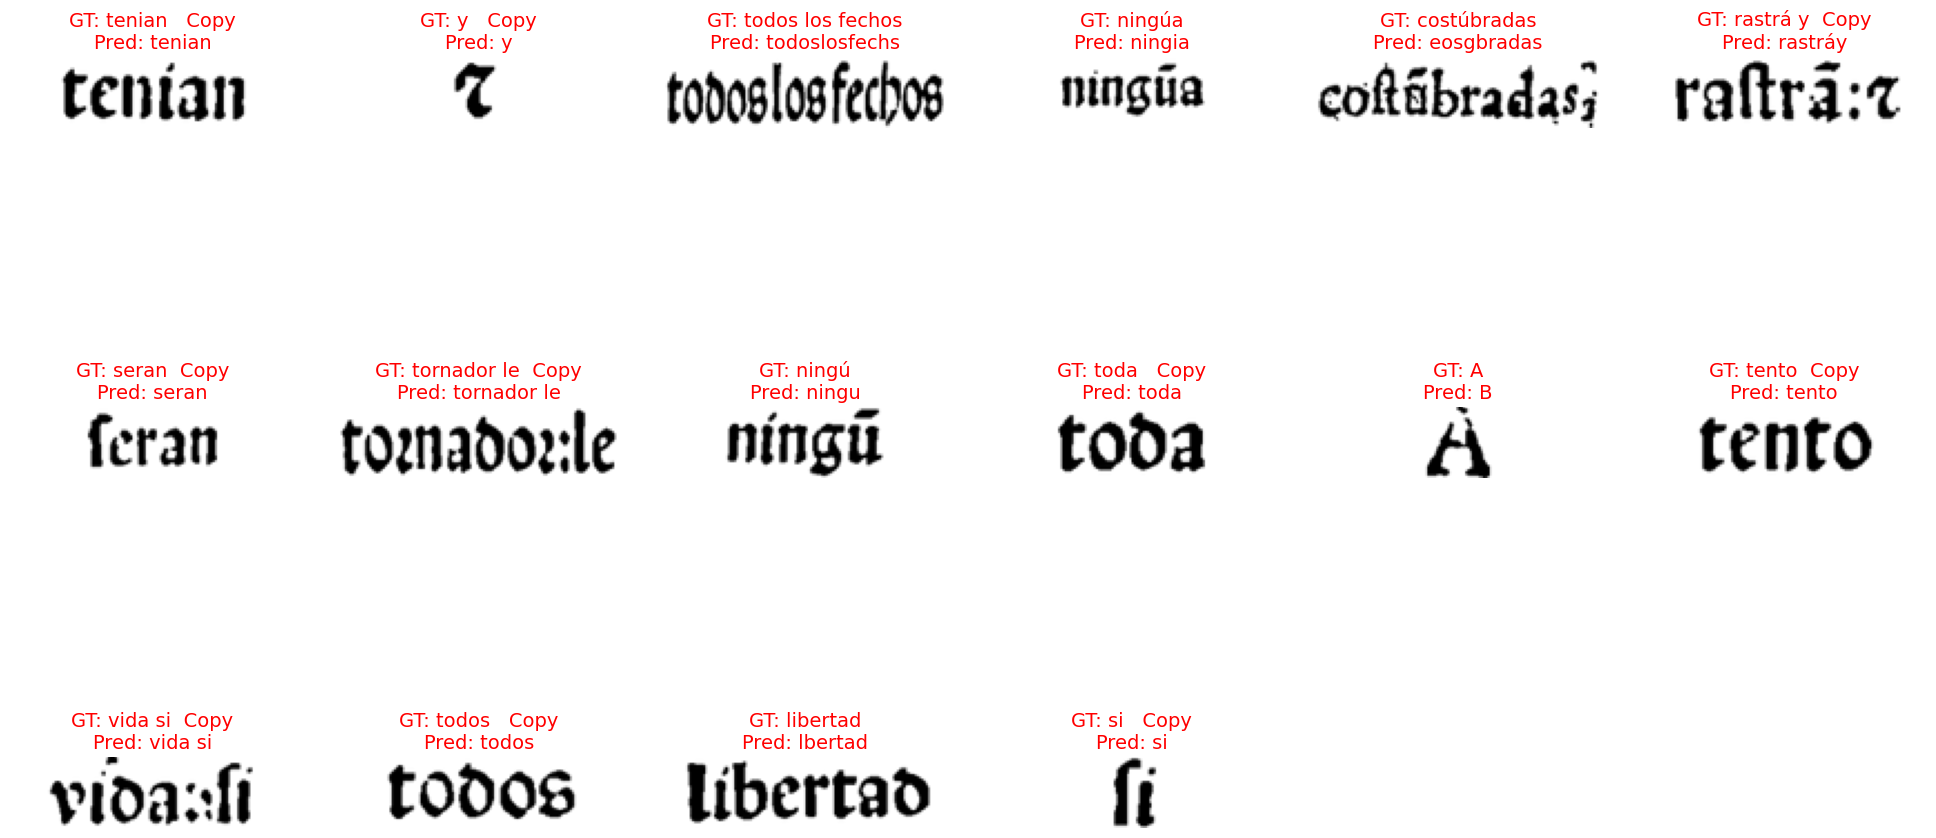

In [74]:
import torch
import matplotlib.pyplot as plt

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = CRNN(IMG_HEIGHT, 1, len(CHARSET) + 1, HIDDEN_SIZE).to(DEVICE)
checkpoint = torch.load("model_synthetic.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Accumulate misclassified samples
misclassified = []

with torch.no_grad():
    for images, _, _, label_strs in val_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds = decode(outputs)  # Your greedy decoder

        for i in range(len(images)):
            gt = label_strs[i]
            pred = preds[i]
            if gt != pred:
                misclassified.append((images[i].cpu(), gt, pred))

# Display misclassified images
num_images = len(misclassified)
if num_images == 0:
    print("All predictions are correct!")
else:
    cols = 6
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(20, rows * 4))

    for idx, (img, gt, pred) in enumerate(misclassified):
        img_np = img.squeeze().numpy() * 0.5 + 0.5  # unnormalize
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(img_np, cmap='gray')
        plt.title(f"GT: {gt}\nPred: {pred}", color='red', fontsize=14)
        plt.axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()


In [3]:
import onnxruntime as ort
import numpy as np
from PIL import Image
import json, unicodedata

# --- load charset ---
with open(r"crnn_spanish_full\charset.txt", "r", encoding="utf-8") as f:
    charset = list(f.read())
with open(r"crnn_spanish_full\charset.json", "r", encoding="utf-8") as f:
    meta = json.load(f)
blank_idx = meta["blank_idx"]
idx_to_char = {i: ch for i, ch in enumerate(charset)}
def nfc(s): return unicodedata.normalize("NFC", s)

def preprocess(path, H=32, fixed_width=None, max_w=512):
    img = Image.open(path).convert("L")
    if fixed_width:
        img = img.resize((fixed_width, H), Image.BILINEAR)
    else:
        w, h = img.size
        new_w = max(1, int(round(w*(H/h))))
        new_w = min(new_w, max_w)
        img = img.resize((new_w, H), Image.BILINEAR)
    arr = (np.array(img).astype(np.float32)/255.0 - 0.5) / 0.5  # normalize to mean=0.5 std=0.5
    arr = arr[None, None, :, :]  # [1,1,H,W]
    return arr

def greedy_decode(logits_TxBxC):
    pred = logits_TxBxC.argmax(-1)  # [T,B]
    seq = pred[:,0].tolist()
    out, prev = [], None
    for t in seq:
        if t == blank_idx: prev = None; continue
        if t == prev: continue
        out.append(idx_to_char[t]); prev = t
    return nfc("".join(out))

# (Optional) inspect the model’s declared input shape
sess = ort.InferenceSession(r"crnn_spanish_full\crnn_spanish.onnx", providers=["CPUExecutionProvider"])
print("Model input:", [(i.name, i.shape) for i in sess.get_inputs()])

img_np = preprocess(r"data/data_4/amistad.png", H=32, fixed_width=None)  # <-- H must be 32 here
logits, = sess.run(["logits_TxBxC"], {"images": img_np.astype(np.float32)})
print(greedy_decode(logits))


Model input: [('images', ['batch', 1, 32, 'width'])]
amistad


In [2]:
import os, json, random, unicodedata
from pathlib import Path
from typing import List, Tuple

import numpy as np
from PIL import Image
import onnxruntime as ort

# optional plotting
import matplotlib.pyplot as plt

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp"}

def nfc(s: str) -> str:
    return unicodedata.normalize("NFC", s)

def list_images(folders: List[Path]) -> List[Path]:
    imgs = []
    for d in folders:
        if d.is_file() and d.suffix.lower() in IMG_EXTS:
            imgs.append(d)
        elif d.is_dir():
            for p in d.rglob("*"):
                if p.is_file() and p.suffix.lower() in IMG_EXTS:
                    imgs.append(p)
    return imgs

def resize_keep_ratio(img: Image.Image, target_h: int, max_w: int = 512) -> Image.Image:
    w, h = img.size
    new_w = max(1, int(round(w * (target_h / h))))
    new_w = min(new_w, max_w)
    return img.resize((new_w, target_h), Image.BILINEAR)

def preprocess_images(
    paths: List[Path], height: int, fixed_width: int = 0, max_w_cap: int = 512
) -> Tuple[np.ndarray, List[Image.Image]]:
    pil_list = []
    widths = []
    for p in paths:
        im = Image.open(p).convert("L")
        if fixed_width and fixed_width > 0:
            im = im.resize((fixed_width, height), Image.BILINEAR)
        else:
            im = resize_keep_ratio(im, height, max_w_cap)
        pil_list.append(im)
        widths.append(im.size[0])

    Wmax = max(widths)
    B = len(pil_list)
    batch = np.ones((B, 1, height, Wmax), dtype=np.float32)
    for i, im in enumerate(pil_list):
        arr = np.array(im).astype(np.float32) / 255.0
        arr = (arr - 0.5) / 0.5
        w = im.size[0]
        batch[i, 0, :, :w] = arr
    return batch, pil_list

def load_charset(charset_dir: Path):
    with open(charset_dir / "charset.txt", "r", encoding="utf-8") as f:
        charset = list(f.read())
    with open(charset_dir / "charset.json", "r", encoding="utf-8") as f:
        meta = json.load(f)
    blank_idx = meta["blank_idx"]
    idx_to_char = {i: ch for i, ch in enumerate(charset)}
    return idx_to_char, blank_idx

def greedy_decode(logits_TxBxC: np.ndarray, blank_idx: int, idx_to_char) -> List[str]:
    pred = logits_TxBxC.argmax(-1)  # [T, B]
    T, B = pred.shape
    out = []
    for b in range(B):
        seq = pred[:, b].tolist()
        prev = None
        chars = []
        for t in seq:
            if t == blank_idx:
                prev = None
                continue
            if t == prev:
                continue
            chars.append(idx_to_char[t])
            prev = t
        out.append(nfc("".join(chars)))
    return out

def infer_random(
    onnx_path: str,
    charset_dir: str,
    folders: List[Path],
    height: int,
    num_samples: int = 24,
    fixed_width: int = 0,
    show: bool = True,
):
    folders = [Path(p) for p in folders]
    imgs = list_images(folders)
    if not imgs:
        raise ValueError("No images found in provided folders.")
    random.shuffle(imgs)
    sel = imgs[:min(num_samples, len(imgs))]

    idx_to_char, blank_idx = load_charset(Path(charset_dir))
    sess = ort.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])

    batch, pil_list = preprocess_images(sel, height, fixed_width)
    logits, = sess.run(["logits_TxBxC"], {"images": batch.astype(np.float32)})
    preds = greedy_decode(logits, blank_idx, idx_to_char)

    # print
    for p, pr in zip(sel, preds):
        print(f"{p.name:<20} => {pr}")

    # plot
    if show:
        cols = 6
        rows = (len(sel) + cols - 1) // cols
        plt.figure(figsize=(cols*3, rows*2))
        for i, (p, im, pr) in enumerate(zip(sel, pil_list, preds)):
            plt.subplot(rows, cols, i+1)
            plt.imshow(im, cmap="gray")
            plt.title(pr, fontsize=9)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

    return list(zip(sel, preds))


Maní.png             => Mani
volútad.png          => vdlútd
épico (2).png        => epicol
Álvarez.png          => Alvarez
Sépronia.png         => Séprónia
educacio.png         => educacó
Féretro.png          => Féretro
Brújula.png          => Brjula
Legítimo.png         => Legitimo
Fácil.png            => Fcil
cápo.png             => eápo
ningú.png            => ningú


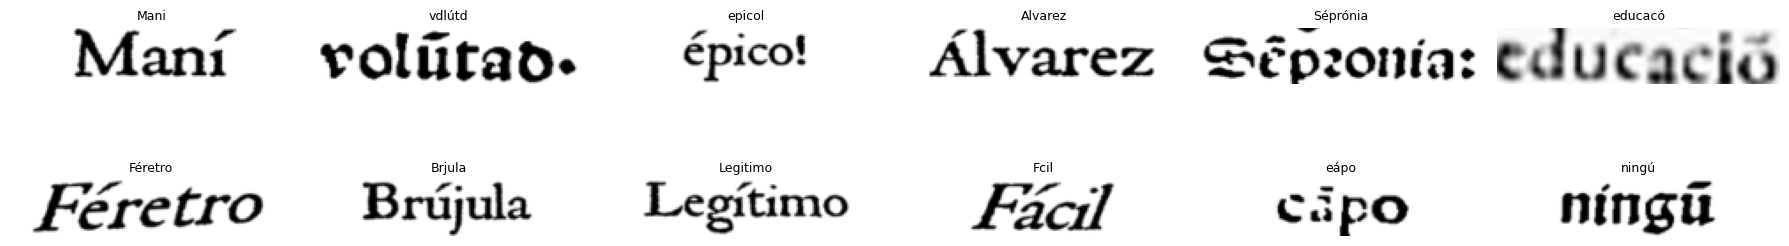

In [6]:
from pathlib import Path

results = infer_random(
    onnx_path="crnn_spanish_full_resume3/crnn_spanish.onnx",
    charset_dir="crnn_spanish_full_resume3",
    folders=[Path("data/data_9")],
    height=32,    # match --height used at export
    num_samples=12,
    show=True
)


In [7]:
# --- CRNN ONNX Export (patched AdaptiveAvgPool2d((1, None))) ---

import torch
import torch.nn as nn
import torch.onnx
import os
from collections import OrderedDict

# Optional runtime check
try:
    import onnxruntime as ort
    import onnx
    HAVE_ORT = True
except Exception:
    HAVE_ORT = False

# ==== CONFIG (edit to match training) ====
IMG_HEIGHT   = 32
HIDDEN_SIZE  = 256
NUM_CLASSES  = 51           # len(CHARSET)+1
CKPT_PATH    = "best_model_NEW.pth"
ONNX_PATH    = "crnn_patched.onnx"
NC           = 1            # 1 for grayscale, 3 for RGB

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== Model definition ====
class CRNN(nn.Module):
    def __init__(self, imgH, nc, nclass, nh):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0
        self.cnn = nn.Sequential(
            nn.Conv2d(nc, 64, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(True),
            nn.MaxPool2d((2, 2), (2, 1), (0, 1)),
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.MaxPool2d((2, 2), (2, 1), (0, 1)),
            nn.AdaptiveAvgPool2d((1, None))
        )
        self.rnn1 = nn.LSTM(512, nh, bidirectional=True)
        self.rnn2 = nn.LSTM(nh * 2, nh, bidirectional=True)
        self.embedding = nn.Linear(nh * 2, nclass)

    def forward(self, x):
        conv = self.cnn(x)
        b, c, h, w = conv.size()
        assert h == 1
        conv = conv.squeeze(2).permute(2, 0, 1)  # [w, b, c]
        rnn_out, _ = self.rnn1(conv)
        rnn_out, _ = self.rnn2(rnn_out)
        return self.embedding(rnn_out)

# ==== Replace AdaptiveAvgPool2d((1, None)) ====
class HeightGlobalAvg(nn.Module):
    def forward(self, x):
        return x.mean(dim=2, keepdim=True)

def patch_adaptive_pool(model: nn.Module) -> int:
    replaced = 0
    for name, child in list(model.named_children()):
        new_child = child
        if isinstance(child, nn.AdaptiveAvgPool2d):
            out = child.output_size
            if isinstance(out, int):
                out = (out, out)
            if isinstance(out, tuple) and len(out) == 2 and out[0] == 1:
                new_child = HeightGlobalAvg()
                setattr(model, name, new_child)
                replaced += 1
        replaced += patch_adaptive_pool(new_child)
    return replaced

# ==== Build and load checkpoint ====
model = CRNN(imgH=IMG_HEIGHT, nc=NC, nclass=NUM_CLASSES, nh=HIDDEN_SIZE).to(DEVICE)
ckpt = torch.load(CKPT_PATH, map_location="cpu")
state = ckpt.get("model_state_dict", ckpt)

# strip DataParallel "module." prefix if needed
if any(k.startswith("module.") for k in state.keys()):
    state = OrderedDict((k.replace("module.", "", 1), v) for k, v in state.items())

missing, unexpected = model.load_state_dict(state, strict=False)
print("[load_state_dict] missing:", missing)
print("[load_state_dict] unexpected:", unexpected)

# ==== Patch pooling and export ====
num_replaced = patch_adaptive_pool(model)
print(f"[patch] Replaced {num_replaced} AdaptiveAvgPool2d layer(s)")
model.eval()

dummy = torch.randn(1, NC, IMG_HEIGHT, 120, device=DEVICE)  # dummy width=120

dynamic_axes = {
    "input": {0: "batch", 3: "width"},
    "logits": {0: "time", 1: "batch"}
}

torch.onnx.export(
    model,
    dummy,
    ONNX_PATH,
    input_names=["input"],
    output_names=["logits"],
    dynamic_axes=dynamic_axes,
    opset_version=13,
    do_constant_folding=True
)
print(f"[onnx] Saved to: {os.path.abspath(ONNX_PATH)}")

# ==== Optional runtime check ====
if HAVE_ORT:
    onnx.checker.check_model(ONNX_PATH)
    sess = ort.InferenceSession(ONNX_PATH, providers=["CPUExecutionProvider"])
    x = dummy.detach().cpu().numpy()
    (y,) = sess.run(None, {"input": x})
    print("[ort] logits shape:", y.shape)


[load_state_dict] missing: []
[load_state_dict] unexpected: []
[patch] Replaced 1 AdaptiveAvgPool2d layer(s)


C:\Users\katej\AppData\Local\Temp\ipykernel_10796\873094413.py:50: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert h == 1
c:\Users\katej\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\onnx\symbolic_opset9.py:2119: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn("Exporting a model to ONNX with a batch_size other than 1, " +


[onnx] Saved to: c:\Users\katej\OneDrive\Documents\GitHub\RenAIssance_fork\RenAIssance_CRNN_OCR_Kate_OReilly_orig\crnn_patched.onnx
